In [1]:
%load_ext autoreload
%autoreload 2

# Tracking Example for @cdeline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import *

Setup some paths using pathlib

In [3]:
CWD = Path.cwd().parent
PATH = CWD/'data'
PATH.ls()

[PosixPath('/home/tc256760/Documents/bifacial_model_validation/data/ines_data.hdf')]

In [4]:
data = pd.read_hdf(PATH/'ines_data.hdf'); data.head()
day = '18 Jul 2017'
data_small = data[day]

## Define the PV plant
We define the PV plant geometry

In [5]:
from vf2d import system_def, merge_data

In [6]:
gps_data = {'Name':'Chambery', 'Latitude': 45.637001, 'Longitude': 5.881, 'Elevation': 235.0, 'TZ':+2}

In [7]:
pvarray_parameters = system_def(n_pvrows=2,
                                tracking=True,
                                n_modules_vertically=2, #number of modules stacked together in each structure. Int.
                                module_size = (1.01, 1.69), #(width, height) this is a portrait module.
                                h_ground = 2.5, #height from the ground for the lower module, in meters.
                                albedo = 0.4, #Albedo from ground, can be constant or a value per timestep. Between 0 and 1.
                                rtr_spacing = 9.4, #row2row distance, in meters.
                                frontSurface = "glass", #glass or ARglass
                                backSurface = "glass",
                                back_measure_points = 10,
                                row_type='first', #where to recover the data, 'first', 'interior' or 'last'
                                gps_data=gps_data, # a dict containing 'Name', 'Latitute', 'Longitude', 'Elevation', 'TZ'
                               )

In [8]:
pvarray_parameters

{'pvfactors': {'n_pvrows': 2,
  'pvrow_height': 2.5,
  'pvrow_width': 3.38,
  'tracking': True,
  'axis_azimuth': 90,
  'surface_tilt': 30,
  'surface_azimuth': 180,
  'albedo': 0.4,
  'gcr': 0.35957446808510635,
  'rho_front_pvrow': 0.04336154977936508,
  'rho_back_pvrow': 0.04336154977936508,
  'cut': {0: {'front': 1, 'back': 10}, 1: {'front': 1, 'back': 1}}},
 'bifacialvf': {'beta': 30,
  'sazm': 180,
  'C': 0.7396449704142012,
  'rtr': 2.7810650887573964,
  'rowType': 'first',
  'transFactor': 0.013,
  'cellRows': 10,
  'PVfrontSurface': 'glass',
  'PVbackSurface': 'glass',
  'albedo': 0.4,
  'tracking': True,
  'backtrack': False},
 'gps_data': {'Name': 'Chambery',
  'Latitude': 45.637001,
  'Longitude': 5.881,
  'Elevation': 235.0,
  'TZ': 2}}

## Merge Data
We create a unified DataFrame with the data needed for the simulation

In [9]:
merged_data = merge_data(data_small.meteo, 
                         data_small.sunpos, 
                         data_small.tracker.surface_tilt,
                         data_small.tracker.surface_azimuth,
                         0.4)

In [10]:
merged_data.head()

,ghi,dni,dhi,zenith,azimuth,elevation,surface_tilt,surface_azimuth,albedo
date,,,,,,,,,
2017-07-18 04:10:00,0.00,0.0,0.00,91.000000,59.572309,0.328591,89.614058,90.0,0.4
2017-07-18 04:15:00,0.00,0.0,0.00,91.000000,60.460925,1.085116,88.748916,90.0,0.4
2017-07-18 04:20:00,10.73,0.0,10.73,88.151694,61.344053,1.848306,87.890731,90.0,0.4
2017-07-18 04:25:00,13.31,0.0,13.32,87.382059,62.221953,2.617941,87.038976,90.0,0.4
2017-07-18 04:30:00,16.51,0.0,16.51,86.606199,63.094892,3.393801,86.193131,90.0,0.4


## PVfactors

In [11]:
from mypvfactors import *

This is just a wrapper around the `run_parallel_engine` and the `run_full_mode` functions from pvfactors. Don't know why with pvfactors 1.2 the parallel mode is so slow.

In [12]:
pvfactors_out = pvfactors_engine_run(merged_data, pvarray_parameters['pvfactors'], parallel=4)

100%|██████████| 45/45 [00:01<00:00, 22.51it/s]
INFO:pvfactors.run:Parallel calculation elapsed time: 2.0680155754089355 sec


In [13]:
pvfactors_out.head()

,qinc_front,qinc_back_mean,qinc_back_0,qinc_back_1,qinc_back_2,qinc_back_3,qinc_back_4,qinc_back_5,qinc_back_6,qinc_back_7,qinc_back_8,qinc_back_9
date,,,,,,,,,,,,
2017-07-18 04:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-18 04:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-18 04:20:00,5.910577,7.433717,7.483248,7.472240,7.461231,7.450223,7.439215,7.428209,7.417204,7.406201,7.395201,7.384203
2017-07-18 04:25:00,7.426101,9.167267,9.228740,9.215072,9.201405,9.187741,9.174080,9.160423,9.146769,9.133120,9.119476,9.105837
2017-07-18 04:30:00,9.362727,11.285068,11.361169,11.344242,11.327319,11.310402,11.293491,11.276587,11.259691,11.242802,11.225922,11.209051


## BifacialVF

In [14]:
from mybifacialvf import *

The `bifacialvf_engine_run` method is just a wrapper around the `simulate` method. It has a nice formater that will transform the output DataFrame in the same format as the one produced by pvfactors to be diectly comparable.

In [15]:
bifacialvf_out = bifacialvf_engine_run(merged_data,  pvarray_parameters['bifacialvf'], gps_data, max_angle=90)

  0%|          | 0/181 [00:00<?, ?it/s]/home/tc256760/anaconda3/envs/bifacial_model_validation/lib/python3.7/site-packages/bifacialvf/vf.py:640: RuntimeWarning: divide by zero encountered in double_scalars
  projectedX1 = PcellX - np.float64(PcellY) / math.tan(startElvDown);      # Projection of ElvDown to ground in -x direction
  6%|▌         | 10/181 [00:00<00:01, 98.81it/s]

 
********* 
Running Simulation for TMY3:  Chambery
Location:   Chambery
Lat:  45.637001  Long:  5.881  Tz  2
Parameters: beta:  0   Sazm:  180   Height:  0.7396449704142012   rtr separation:  2.7810650887573964   Row type:  first   Albedo:  0.4
Saving into output.csv
 
 
 ***** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  False


100%|██████████| 181/181 [00:01<00:00, 96.05it/s]

Finished


In [16]:
bifacialvf_out.head()

,qinc_front,qinc_back_mean,qinc_back_0,qinc_back_1,qinc_back_2,qinc_back_3,qinc_back_4,qinc_back_5,qinc_back_6,qinc_back_7,qinc_back_8,qinc_back_9
date,,,,,,,,,,,,
2017-07-18 04:20:00,7.211362,5.329768,5.926075,5.791286,5.657167,5.523821,5.391342,5.259751,5.128703,4.997224,4.871040,4.751275
2017-07-18 04:25:00,7.947250,6.373815,6.373969,6.563377,6.752305,6.763937,6.599689,6.436576,6.274195,6.111470,5.955210,5.907420
2017-07-18 04:30:00,9.948410,7.804025,7.809775,8.039927,8.238935,8.250803,8.047345,7.876175,7.675292,7.474216,7.405548,7.222232
2017-07-18 04:35:00,11.990029,9.194295,9.177013,9.447127,9.716040,9.728001,9.485531,9.244793,9.005228,8.915169,8.720577,8.503467
2017-07-18 04:40:00,13.868856,10.444367,10.385352,10.692262,10.997489,11.009920,10.908970,10.631951,10.356167,10.080451,9.814589,9.566522


## Comparison of pvfactors and BifacialVF
As we can see, for the same measurement point (the 3rd point from the top) the outputs of both models are very different.

In [17]:
pvfactors_out.head()

,qinc_front,qinc_back_mean,qinc_back_0,qinc_back_1,qinc_back_2,qinc_back_3,qinc_back_4,qinc_back_5,qinc_back_6,qinc_back_7,qinc_back_8,qinc_back_9
date,,,,,,,,,,,,
2017-07-18 04:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-18 04:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-07-18 04:20:00,5.910577,7.433717,7.483248,7.472240,7.461231,7.450223,7.439215,7.428209,7.417204,7.406201,7.395201,7.384203
2017-07-18 04:25:00,7.426101,9.167267,9.228740,9.215072,9.201405,9.187741,9.174080,9.160423,9.146769,9.133120,9.119476,9.105837
2017-07-18 04:30:00,9.362727,11.285068,11.361169,11.344242,11.327319,11.310402,11.293491,11.276587,11.259691,11.242802,11.225922,11.209051


## Sanity check of tracking strategies, external computed tracking with internal bifacialvf tracking

In [18]:
output_file_bvf = pd.read_csv('output.csv', header=2, index_col='date', parse_dates=True)

In [19]:
output_file_bvf.columns

Index(['DNI', 'DHI', 'decHRs', 'ghi', 'inc', 'zen', 'azm', 'pvFrontSH',
       'aveFrontGroundGHI', 'GTIfrontBroadBand', 'pvBackSH',
       'aveBackGroundGHI', 'GTIbackBroadBand', 'maxShadow', 'Tamb', 'Vwind',
       'No_1_RowFrontGTI', 'No_2_RowFrontGTI', 'No_3_RowFrontGTI',
       'No_4_RowFrontGTI', 'No_5_RowFrontGTI', 'No_6_RowFrontGTI',
       'No_7_RowFrontGTI', 'No_8_RowFrontGTI', 'No_9_RowFrontGTI',
       'No_10_RowFrontGTI', 'No_1_RowBackGTI', 'No_2_RowBackGTI',
       'No_3_RowBackGTI', 'No_4_RowBackGTI', 'No_5_RowBackGTI',
       'No_6_RowBackGTI', 'No_7_RowBackGTI', 'No_8_RowBackGTI',
       'No_9_RowBackGTI', 'No_10_RowBackGTI', 'beta', 'sazm', 'height', 'D'],
      dtype='object')

## Dont know where this D and hegiht come from?

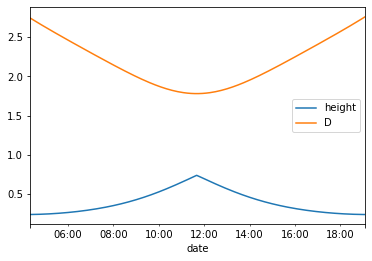

In [20]:
output_file_bvf.height.plot()
output_file_bvf.D.plot()
plt.legend()

The angle is good

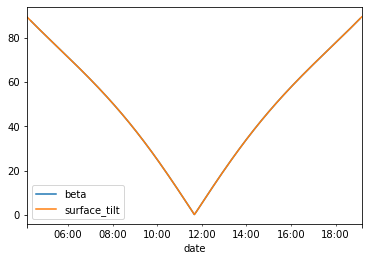

In [21]:
output_file_bvf.beta.plot()
merged_data.surface_tilt.plot()
plt.legend()

## Back

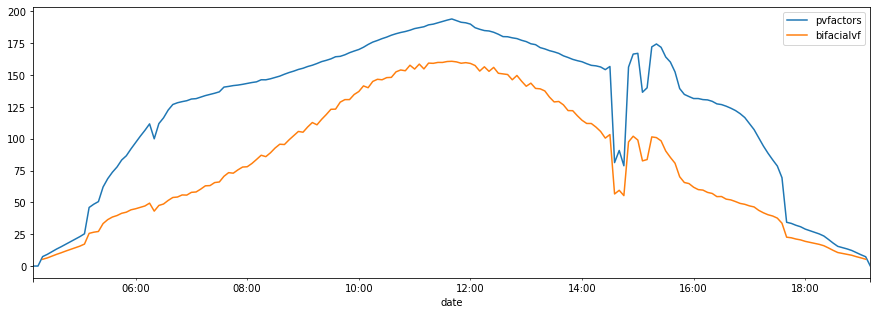

In [22]:
pvfactors_out[day].qinc_back_mean.plot(figsize=(15,5))
bifacialvf_out[day].qinc_back_mean.plot()
plt.legend(['pvfactors', 'bifacialvf'])

## Front

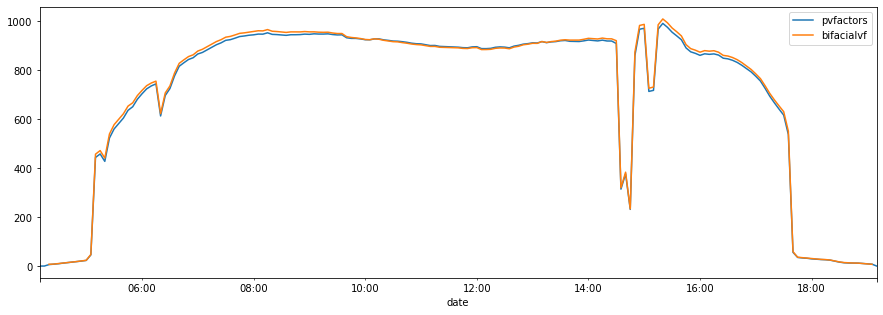

In [23]:
pvfactors_out[day].qinc_front.plot(figsize=(15,5))
bifacialvf_out[day].qinc_front.plot()
plt.legend(['pvfactors', 'bifacialvf'])